# HMC2

1129
[[ 1.06384749  0.50773997]
 [ 0.50773997  2.01715948]]


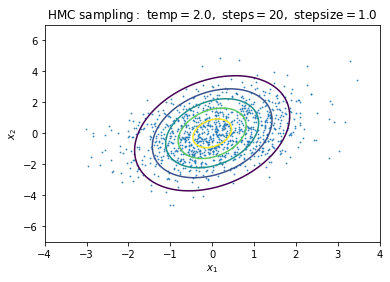

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 15 20:04:50 2018
"""

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

class HMC:    
    def __init__(self, P=2000, N=20, temp=2.0, distribution=None, epsilon=1.0):
        self.T = temp
        self.X = np.empty((2,0))
        self.D = distribution
        self.N = N
        self.e = epsilon
        self.P = P
        
    def leapfrog(self, p_t, x_t, g_t, e):
        p_half = p_t - e * .5 * g_t
        x_new = x_t + e * p_half

        for i in np.arange(0, self.N):
            g_new = self.D.grad(x_new)
            p_half = p_half - e * g_new
            x_new = x_new + e * p_half

        p_new = p_half - e * .5 * g_t
        return p_new, x_new
    
    def hmc(self):
        x = np.random.rand(2)[:,np.newaxis]
        self.X = np.hstack((self.X, x))
        
        for i in np.arange(0, self.P):
            p = np.random.randn(2)[:,np.newaxis]
            e_old = self.energy(p, x)
            
            gradient = self.D.grad(x)
            p_n, x_n = self.leapfrog(p, x, gradient, self.e)
            e_new = self.energy(p_n, x_n)
            u = np.random.rand()
            r = self.acceptance_ratio(e_old, e_new)
            r = min(r, 1)
            if r >= u:
                self.X = np.hstack((self.X, x_n))
                x = x_n
            
    def acceptance_ratio(self, e_old, e_new):
            return np.exp( (e_old - e_new) / self.T )
            
    def energy(self, p, x):
        return .5 * p.T.dot(p) + self.D.p(x)
    
    def output(self):
        print(self.X.shape[1])
        print((self.X.dot(self.X.T))/self.X.shape[1])
        delta = 0.025
        X = np.arange(-4, 4, delta)
        Y = np.arange(-7, 7, delta)
        X, Y = np.meshgrid(X, Y)
        Z = mlab.bivariate_normal(X, Y, 1.0, 2.0, 0.0, 0.0, .6)
    
        CS = plt.contour(X, Y, Z)
        plt.title(r'$\mathrm{HMC\ sampling:\ temp=2.0,\ steps=20,\ stepsize=1.0}$')
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.scatter(self.X[0],self.X[1],alpha=0.8,s=0.7)
        plt.xlim(-4,4)
        plt.ylim(-7,7)
        plt.show()
        
class BiGaussian:
    def __init__(self, mean=np.array([.0, .0]), cov=np.array([[1., .0], [.0, 1.]])):
        self.u = mean
        self.cov = cov
    
    def p(self, x):
        inv = np.linalg.inv(self.cov)
        x_prime = x - self.u[:, np.newaxis]
        return .5 * x_prime.T.dot(inv.dot(x_prime))
    
    def grad(self, x):
        inv = np.linalg.inv(self.cov)
        x_prime = x - self.u[:, np.newaxis]
        return inv.dot(x_prime)
    
    def dis(self, samples):
        return np.abs(np.linalg.norm(samples.dot(samples.T)/samples.shape[1] - self.cov))

def main():
    d = BiGaussian(cov=np.array([[1., .6], [.6, 2.]]))
    s = HMC(distribution=d)
    s.hmc()
    s.output()

if __name__ == '__main__':
    main()